In [3]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from time import time

import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

In [4]:
credentials = ('sushant', 'Mross@fmaB')
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=15, http_auth=credentials)
es.ping()

True

`June 18, 2019`

In [118]:
agg_my_query = {
"size": 0,
"query": {
   "bool": {
   "must": [
       {"term":{"src_VO":"ATLAS"}},
       {"term":{"dest_VO":"ATLAS"}},
       {
         "range":{
           "delay_mean": {
             "gte": 0
           }
         }
       },
       {
       "range": {
           "timestamp": {
           "gte": 1560891124000,
           "lte": 1560891125000,
           "format": "epoch_millis"
           }
       }
       }
   ]
   }
},
"aggs": {
   "2": {
   "terms": {
       "field": "src_site",
       "size": 999,
       "order": {
       "_key": "desc"
       }
   },
   "aggs": {
       "3": {
       "terms": {
           "field": "dest_site",
           "size": 999,
           "order": {
           "_key": "desc"
           }
       },
       "aggs": {
           "1": {
           "avg": {
               "field": "delay_mean"
           }
           }
       }
       }
   }
   }
}
}



In [158]:
my_query = {
    "size":1,
    "_source":["src","dest","timestamp"],
    "sort":[{"timestamp":"asc"}]
}

In [159]:
scroll = scan(client=es, index='ps_trace', query=my_query)
# agg_scroll = es.search(index='ps_owd',body = agg_my_query)

`June 19, 2019`

In [26]:
def getUniqueCount(es, index, field):
    '''
    Get Unique Count returns the distinct count of the field in the index.
    Field : Attribute In the Index (String)
    Index: Index in which we want ot search the field.
    '''
    query = {
    'aggs':{
        'uniq_val':{
            'cardinality':{
                'field':field,
                }
            }
        }    
    }
    try:
        result = es.search(index='ps_trace', body=query)
        val = result['aggregations']['uniq_val']['value']
        return val
    except Exception as e:
        print(e)
        return None

In [91]:
countOf = ['dest_host', 'dest', 'src_host', 'src', 'hash']
for i in countOf:
    print(i," : ", getUniqueCount('ps_trace',i))

dest_host  :  807
dest  :  929
src_host  :  483
src  :  549
hash  :  4145179


`June 20, 2019`

In [52]:
def getUniqueHashBy(es, index, field):
    '''
    Get Unique Count returns the distinct count of the for each value of field in the index.
    Field : Attribute In the Index (String)
    Index: Index in which we want ot search the field.
    '''
    sz = getUniqueCount(es,index, field)
    print("Size : {}".format(sz))
    
    query = {
        "size":0,
        "aggs":{
            "FieldCounts":{
                "terms":{
                    "field":field,
                    "size":sz
                }
            }
        }
    }
    
    try:
        result = es.search(index=index, body=query)
        val = result['aggregations']['FieldCounts']['buckets']
        return val
    except Exception as e:
        print(e)
        return None

In [101]:
countOfBy = ['dest_host', 'dest', 'src_host', 'src']
for i in countOfBy:
    (i," : ", getUniqueCountBy(es,'ps_trace',i))

In [126]:
src_data = getUniqueHashBy(es,'ps_trace','src_host')
dest_data = getUniqueHashBy(es,'ps_trace','dest_host')

Size : 483
Size : 807


In [141]:
n = 100

def plotByHist(data, n):
    cdata = {}
    for result in data:
        cdata[result['key']] = result['doc_count']
    
    labels = list(cdata.keys())
    values = list(cdata.values())
    plt.figure(figsize=(16,9), dpi=512)
    plt.bar(labels[:n], values[:n])
    plt.xticks(rotation=90,fontsize=6)

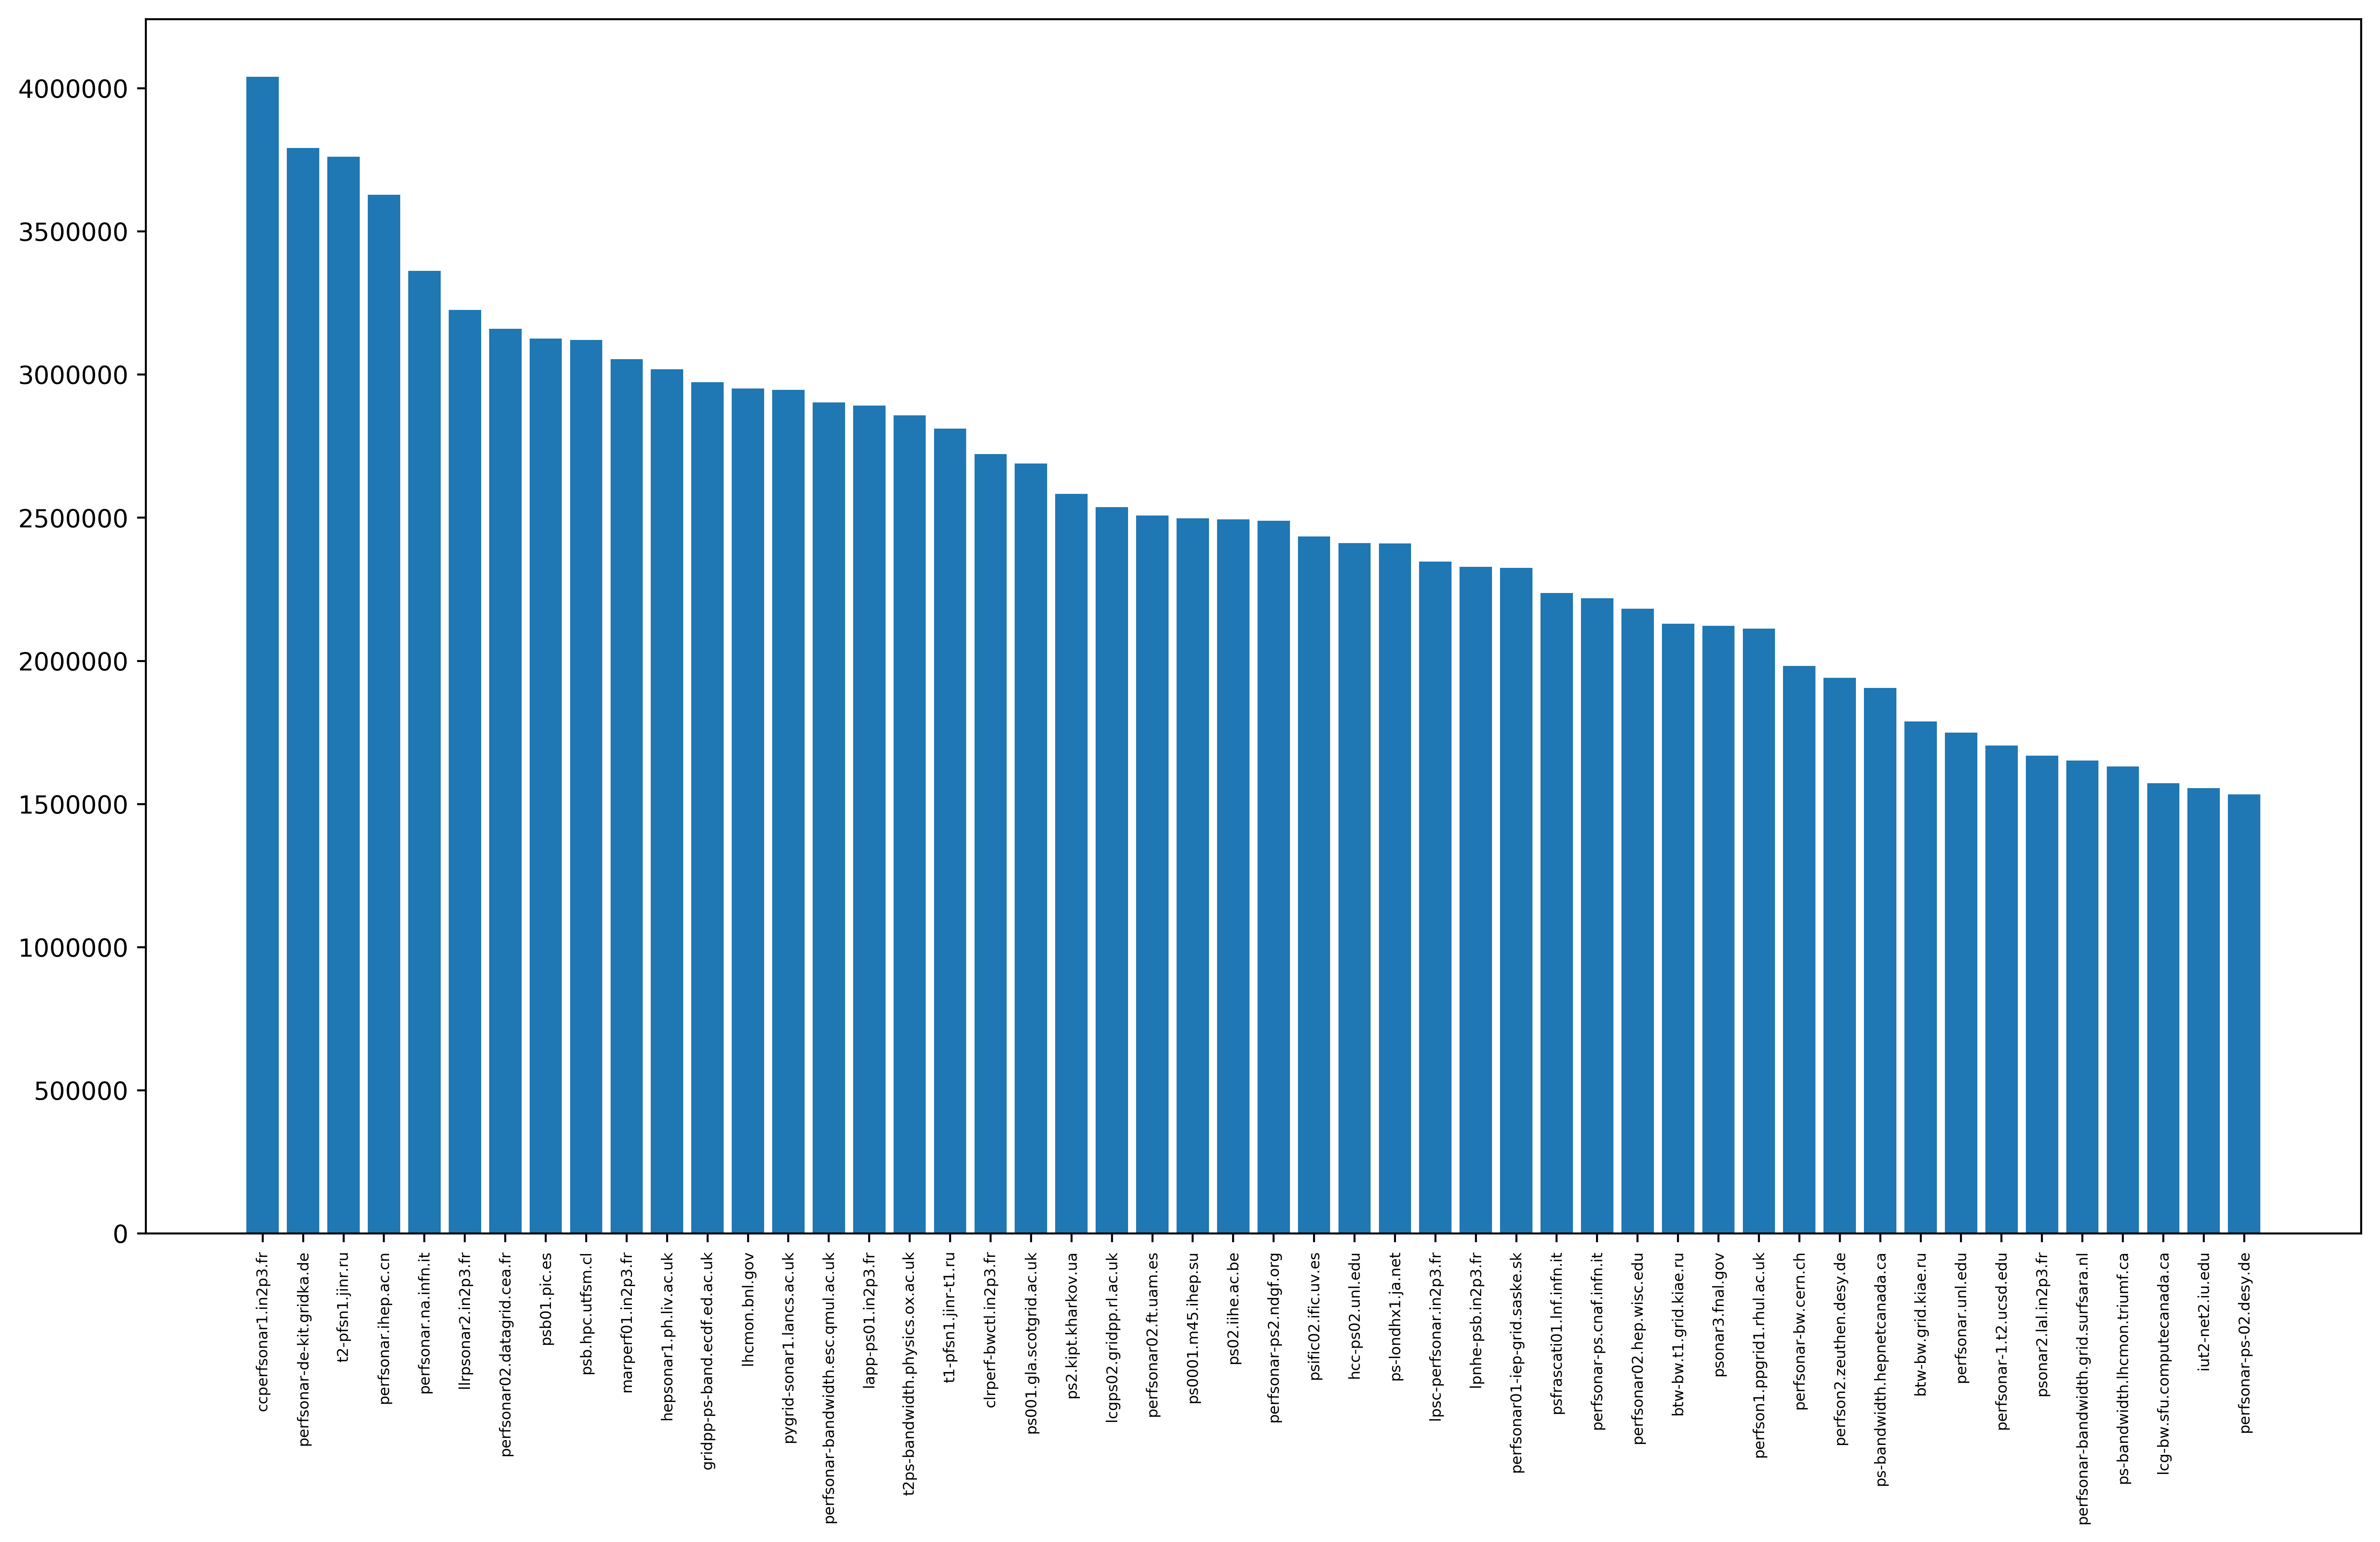

In [142]:
plotByHist(src_data,50)

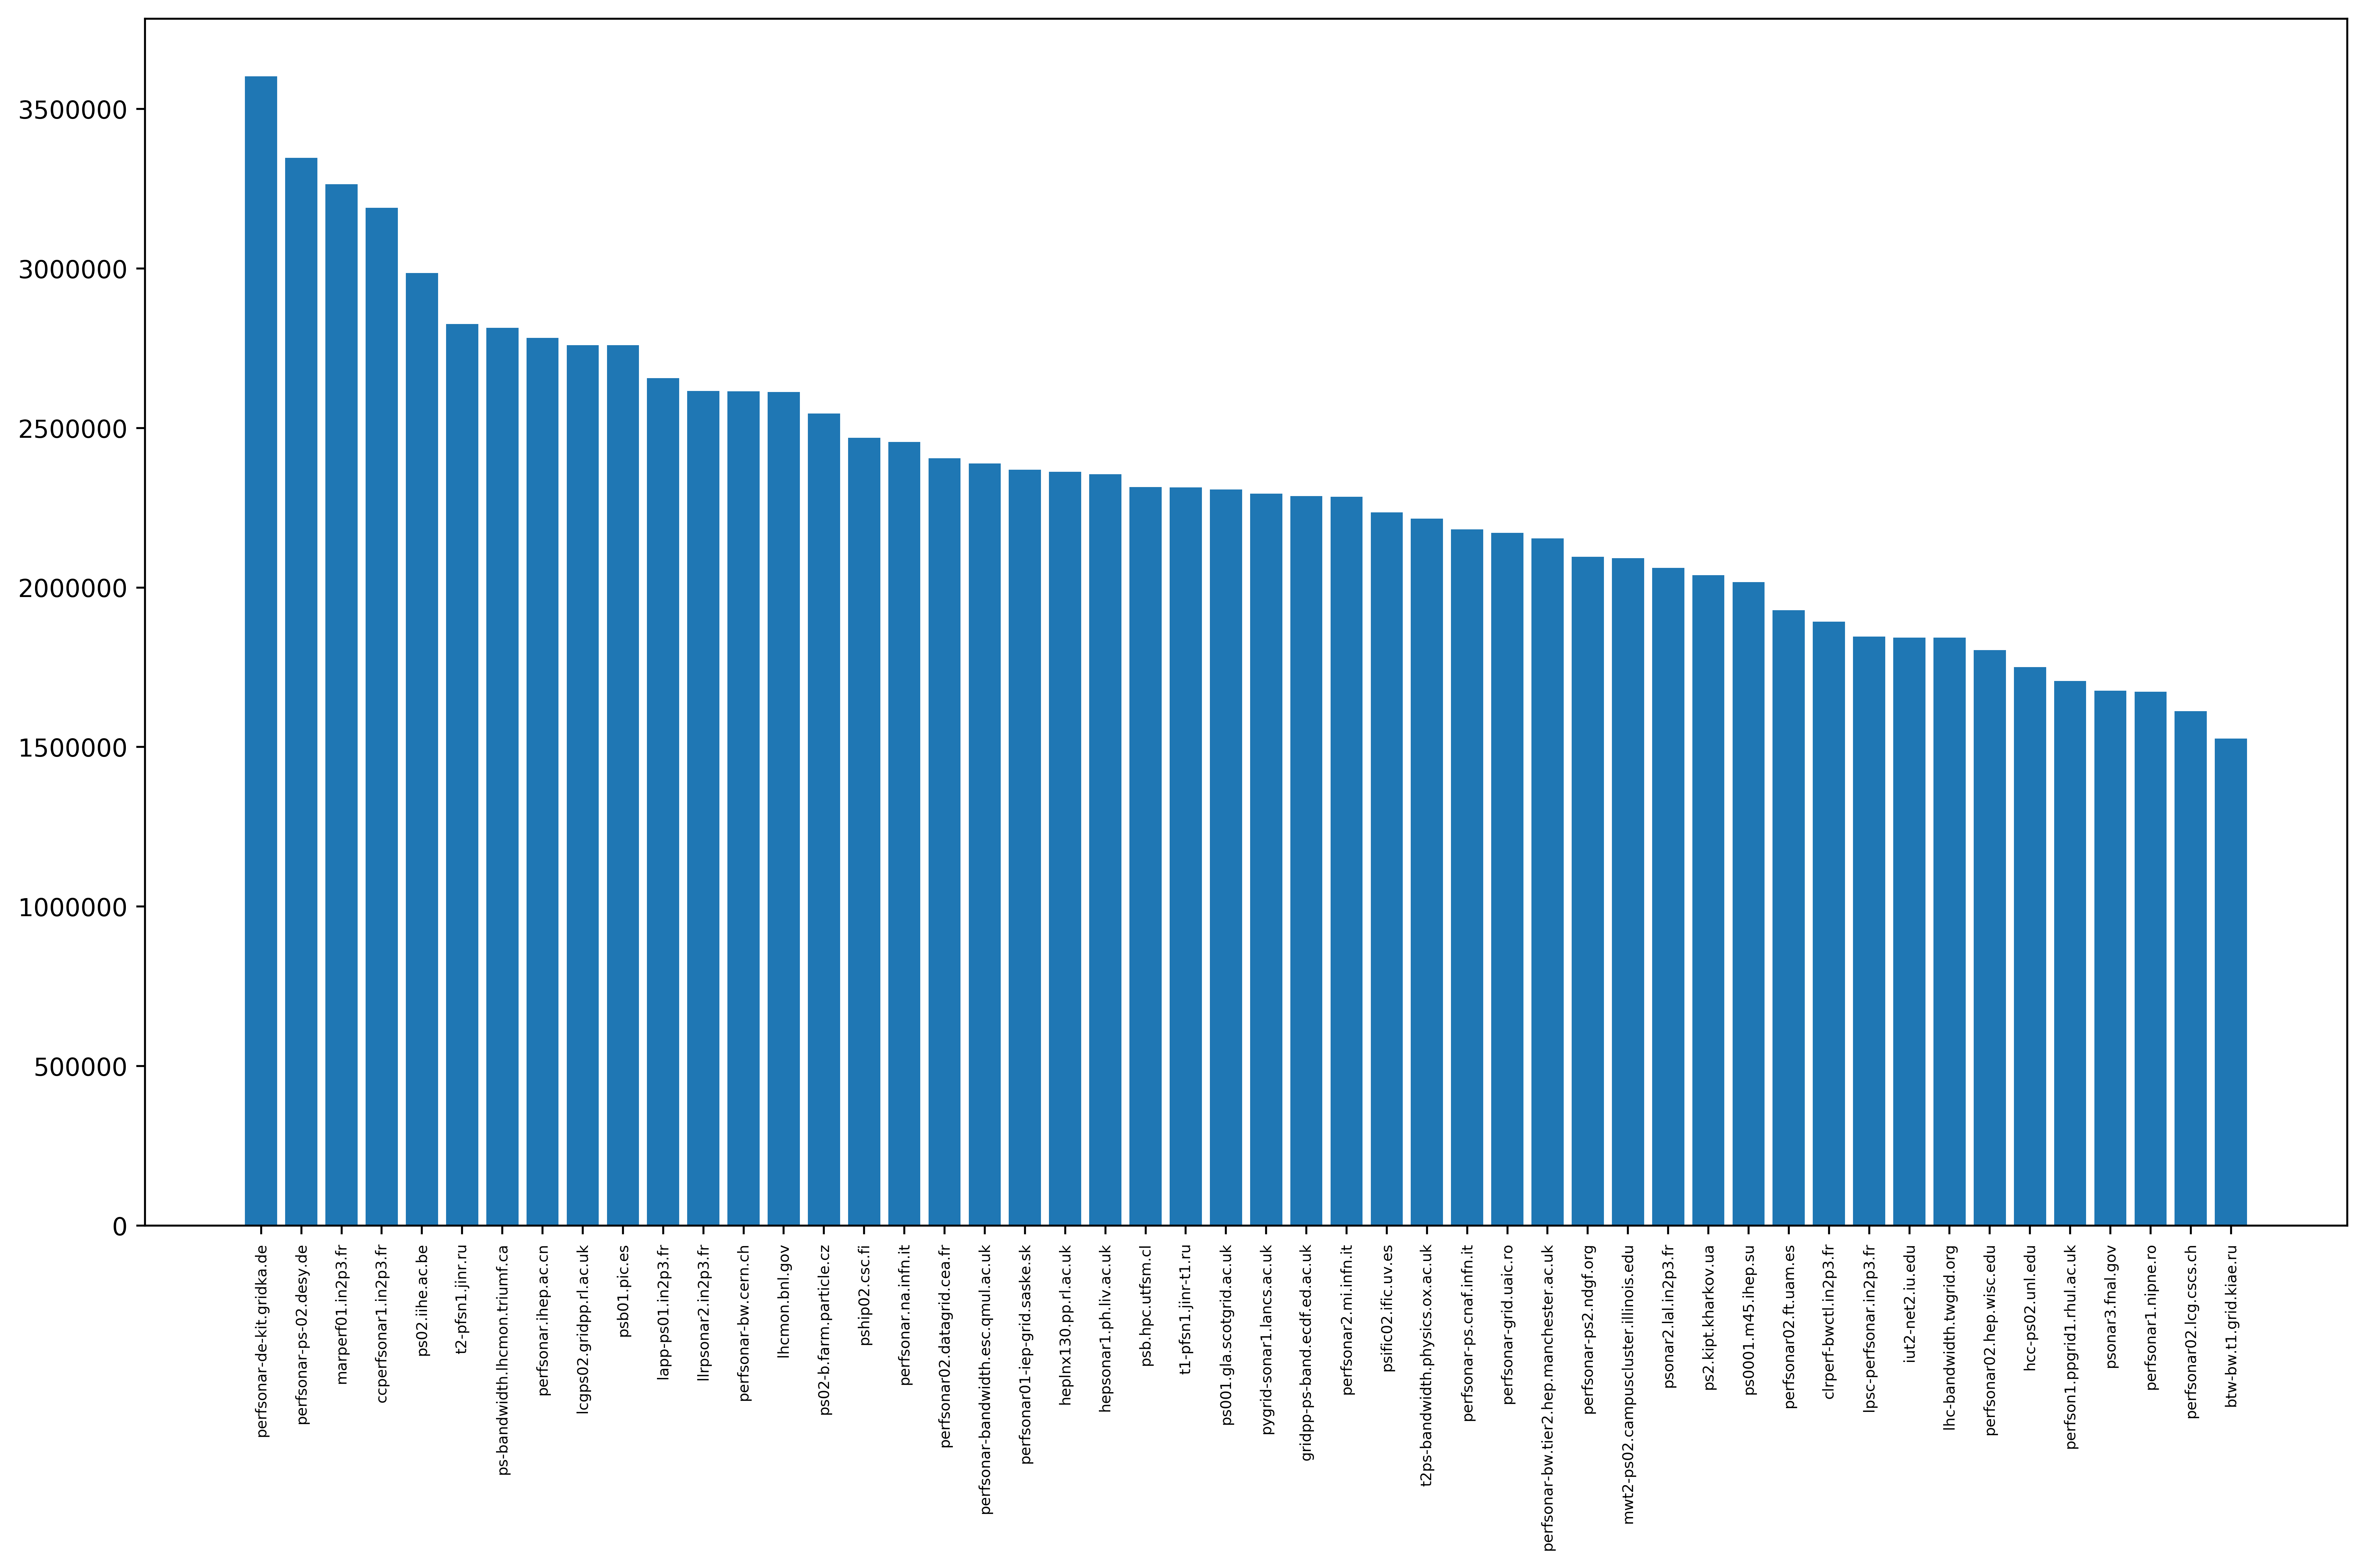

In [143]:
plotByHist(dest_data, 50)

`June 21, 2019`

In [37]:
def getNumHashesBetweenHostsInTimeRange(es, index, time_from, time_to):
    '''
    es: Elastic Search connection object
    index: Index to be searched/scanned within
    Time Range
    Time Format: YYYYMMDD'T'HHMMSS'Z' (strings)
    '''
    
    pre_query = {
    "query": {
      "range": {
        "timestamp": {
          "gte": time_from,
          "lte": time_to
        }
      }
    }, 
    "size":0,
    "aggs":{
        
        "uniq_val":{
            "cardinality":{
                    "script":{
                      "source": "doc['src_host'].value + ',' + doc['dest_host'].value",
                      "lang": "painless"
                    }
                }
            }
        }    
    }

    pre_result = es.search(index, body = pre_query)
    sz = pre_result['aggregations']['uniq_val']['value']
    
    query = {
    "size": 0, 
    "query": {
      "range": {
        "timestamp": {
          "gte": time_from,
          "lte": time_to
        }
      }
    },
    "aggs":{
        "uniq_val":{
            "terms":{
                    "script":{
                      "source": "doc['src_host'].value + ',' + doc['dest_host'].value",
                      "lang": "painless"
                    },
                "size":sz,
                },
            "aggs":{
                "uniq_hash":{
                    "cardinality":{
                        "field":"hash"
                    }
                }
            }
          }
        }    
    }
    
    scroll = scan(client=es, index=index, query=query)
#     X = es.search(index, body=query)
    
    count = 0
    for i in scroll:
        print(i)
        count += 1
        if count % 25 == 0 :
            return 
        
    

In [38]:
getNumHashesBetweenHostsInTimeRange(es,'ps_trace','20190517T000000Z','20190601T000000Z')

{'_index': 'ps_trace-2019.5.17', '_type': 'doc', '_id': '-1259891265388163690', '_score': None, '_source': {'MA': '130.209.239.123', 'src': '130.209.239.123', 'dest': '193.58.172.57', 'src_host': 'ps001.gla.scotgrid.ac.uk', 'dest_host': 'ps02.iihe.ac.be', 'ipv6': False, 'src_site': 'UKI-SCOTGRID-GLASGOW', 'src_VO': 'ATLAS', 'dest_site': 'BEgrid-ULB-VUB', 'dest_VO': '', 'src_production': True, 'dest_production': True, 'timestamp': 1558051409000, 'hops': ['130.209.239.4', '130.209.2.205', '146.97.154.5', '146.97.73.33', '146.97.38.25', '146.97.33.53', '146.97.33.41', '146.97.33.21', '146.97.33.1', '62.40.124.197', '62.40.98.168', '62.40.124.162', '193.191.3.98'], 'asns': [786, 786, 786, 786, 786, 786, 786, 786, 786, 20965, 20965, 20965, 2611], 'rtts': [0.2, 0.2, 2.7, 0.5, 0.6, 5.2, 7.0, 10.9, 11.299999999999999, 11.2, 15.7, 15.9, 201.2], 'ttls': [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15], 'n_hops': 13, 'max_rtt': 201.2, 'hash': 4416657144475687217}, 'sort': [0]}
{'_index': 'ps_trace-20